# Carvana

In this code, we will be re-visiting Carvana. We will explore evaluation metrics for classification problems, and we will gain experience in working with categorical independent variables.

## Import packages

First, we will import our normal selection of packages. However, this time, we will be importing the classification version of the models we've been using. These will have different names, but generally, the parameters will be identical or nearly so.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dill

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, confusion_matrix, plot_roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from xgboost import XGBClassifier

from patsy import dmatrices, dmatrix, build_design_matrices

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

In [3]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Load the Data

We have seen this data before, but this time we are going to use the full training set from Kaggle (the previous training set was a cut down version to allow for an in class competition), and we will use the full test set from Kaggle as well. We will submit our results for the test set to Kaggle in order to finally evaluate our models.

In [4]:
df_train = pd.read_csv('training.csv') 
df_test = pd.read_csv('test.csv') 

In [5]:
df_train.shape

(72983, 34)

In [6]:
df_test.shape

(48707, 33)

## Summarize the data

Let's take a more holistic look at the data.

In [7]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

In [8]:
summarize_dataframe(df_train)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RefId,int64,0,72983,72983.0,,,,36511.428497,21077.241302,1.0,18257.5,36514.0,54764.5,73014.0
IsBadBuy,int64,0,2,72983.0,,,,0.122988,0.328425,0.0,0.0,0.0,0.0,1.0
PurchDate,object,0,517,72983.0,517,11/23/2010,384,,,,,,,
Auction,object,0,3,72983.0,3,MANHEIM,41043,,,,,,,
VehYear,int64,0,10,72983.0,,,,2005.343052,1.731252,2001.0,2004.0,2005.0,2007.0,2010.0
VehicleAge,int64,0,10,72983.0,,,,4.176644,1.71221,0.0,3.0,4.0,5.0,9.0
Make,object,0,33,72983.0,33,CHEVROLET,17248,,,,,,,
Model,object,0,1063,72983.0,1063,PT CRUISER,2329,,,,,,,
Trim,object,2360,134,70623.0,134,Bas,13950,,,,,,,
SubModel,object,8,863,72975.0,863,4D SEDAN,15236,,,,,,,


## Engineer features

As long as we don't need to use any information other than what we have, we can go ahead and engineer new features on the full training set. Here we will convert PurchDate column from an object (i.e., string) to a formal datetime object in Python.

In [9]:
df_train['PurchDate'] = pd.to_datetime(df_train['PurchDate'], format='%m/%d/%Y')

df_test['PurchDate'] = pd.to_datetime(df_test['PurchDate'], format='%m/%d/%Y')

Instead of using the variable directly, we will engineer two new features based on the purchase date: month and year.

In [10]:
df_train['Month'] = df_train['PurchDate'].dt.month
df_train['Year'] = df_train['PurchDate'].dt.year

df_test['Month'] = df_test['PurchDate'].dt.month
df_test['Year'] = df_test['PurchDate'].dt.year

Note that any feature engineering that can't be done with only a single row of data (i.e. you need the mean of a whole column), should only be done after splitting.

## Split Into Training and Validation

Now we will split the train dataset into a smaller training and a validation set, as is best practice.

In [11]:
df_smaller_train, df_validation = train_test_split(df_train, test_size = 0.25, random_state = 201)

There is a bug that gives a warning later on in the code which you can fix by making copies of the above dataframe. This step is unnecessary, but it avoids showing a warning, so I'm going to include it.

In [12]:
df_smaller_train = df_smaller_train.copy()
df_validation = df_validation.copy()

## Imputing Missing Values

We see that we have a lot of missing values among both continuous and categorical variables. We've seen how to impute missing values for continuous variables several times before. We generally take the mean of the data that is there, and then fill in the missing values with that mean. However, this may not always be the best option depending on the data, particularly if the fact that the data is missing is likely to be meaningful.

In [13]:
continuous_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

Imputing over categorical variables is challenging for three reasons. First, there are two equally reasonable ways to fill in missing values; you can either replace the missing values with the most common value in a category (for example "SILVER" is the most common value for `Color` in this dataset, for any missing values in the dataset, you would replace it with silver), or you can replace the value with some value that indicates it is missing (like the word "MISSING") and treat that like another category. The first method assumes that data is just accidentally missing, while the second assumes that there is something meaningful in it missing, which seems to be more common for categorical data than continuous data. As we've seen before `WheelTypeID` very much falls into this latter category.

The second way in which categorical variables are challenging is that often times there are many, many values for a categorical variable, which means that there are very few data points associated with each category. A good example of this is `Model` for which there are `1063` unique values. The models with few observations are unlikely to be predictive, but we may still want to include the models with lots of observations and then lump everything else into an "Other" category. We also may want to do this either by the percentage of the dataset (e.g. any category that is less than 10% of the data should be lumped in other) or by the number of samples in the dataset (e.g. any category that has fewer than 1000 samples should be lumped in "Other").

The third reason that we imputing is challenging for categorical data is that the test set may have categories that we have never seen before. For example, if a new model car comes out, and we are trying to use model to predict the probability of `IsBadBuy`, then we won't have that model in the data we trained on. The simplest way to handle this is by lumping any of these observations into an "Other" category.

Unfortunately, there is not any pre-packaged transformer that will do all of these things for us. Fortunately, it's not hard to write a custom transformer that will do all of these things for us. I have done so below. Note that you do not need to understand how I wrote this. It will be sufficient to know how to use it.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalImputer(BaseEstimator, TransformerMixin):
    """
    Custom defined imputer for categorical data. This allows you to specify an 
    other class where any category that doesn't meet the requirements necessary to
    be in 
    """
    
    def __init__(self, other_threshold=0, 
                 other_label="OTHER",
                 missing_first=True,
                 missing_values=np.nan, 
                 strategy='constant', 
                 fill_value="MISSING", 
                 verbose=0, 
                 copy=True, 
                 add_indicator=False):
        self.add_indicator = add_indicator
        self.copy=copy
        self.verbose=verbose
        self.fill_value=fill_value
        self.missing_first=missing_first
        self.missing_values=missing_values
        self.other_label=other_label
        self.other_threshold=other_threshold
        self.strategy=strategy
        if hasattr(missing_values, "__iter__"):
            self.missing_values = missing_values
        else:
            self.missing_values = [missing_values]
        self._imputer = SimpleImputer(missing_values=missing_values, strategy=strategy, fill_value=fill_value, verbose=verbose, copy=copy, add_indicator=False)
        self._column_categories = {}

        
    def fit(self, X, y=None):
        if type(self.other_threshold) == int or type(self.other_threshold) == float:
            other_threshold = [self.other_threshold]*len(X.columns)
        elif len(self.other_threshold) == len(X.columns):
            other_threshold = self.other_threshold
        else:
            raise TypeError("other_threshold must be either a single number or a list of numbers equal to the number of columns.")

        i = 0
        X = X.copy()
        X = X[:].astype(object)
        if self.missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        column_categories = {}
        for column in X.columns:
            if other_threshold[i] < 1:
                other_threshold[i] = other_threshold[i]*X[column].shape[0]
            
            value_counts = X[column].value_counts()
            categories = [category for category in value_counts.index if value_counts.loc[category] >= other_threshold[i]]
            if value_counts.iloc[-1] >= other_threshold[i]:
                categories[-1] = self.other_label
            else:
                categories.append(self.other_label)
            
            self._column_categories[column] = categories
            i = i + 1
        
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X = X[:].astype(object)
        if self.missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        for column in X.columns:
            X.loc[~X[column].isin(self._column_categories[column]) & ~X[column].isin(self.missing_values), column] = self.other_label
        return pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)[:].astype(str)

While the above block of text may look intimidating, you really do not need to understand the actual code. You should know how to use the code, and if you want to use this function in a different notebook, you should just copy and paste the above block of code.

To use `CategoricalImputer` you don't necessarily need to specify anything. If you just use it as follows:

```python
imputer=CategoricalImputer()
imputer.fit(X[["Categorical Column 1", "Categorical Column 2"]])
imputer.transform(X[["Categorical Column 1", "Categorical Column 2"]])
```

it will just replace all missing values (`np.nan`) with the word "MISSING". However, you can specify a few other helpful items:
  * `other_threshold`: This will set the threshold for which if there are any categories below the threshold, it will replace them with the word "OTHER. If you specify a number between 0 and 1, it will be interpreted as a fraction of the full data (so .1 will mean that the category has to make up at least 10% of the data to be included, otherwise it becomes "OTHER"). If you specify an integer, it will indicate the absolute number of rows that have to have that category (e.g. 1000 means that 1000 rows have to have that category or it gets grouped with "OTHER"). You can also specify a list that is as long as the number of columns you have (so if you are imputing over three columns, you need a list with three items), and the threshold for the column will correspond to the threshold in the same place in the list. **By default this is `0`.**
  * `other_label`: This sets the label for the other category. **By default this is `"OTHER"`.**
  * `missing_first`: If this is `True`, then missing values are imputed first and then the missing category is treated like any other category. This means that if the number of missing observations is below the threshold, it will be lumped into "OTHER". If this is `False`, then missing values will be imputed at the end, so you will know which values were missing even if there were only a few. **By default this is `True`.**

Finally, you can set all imputer values just like the `SimpleImputer` function where the documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). The defaults are `missing_values=np.nan, strategy='constant', fill_value="MISSING"`, which are generally reasonable for a categorical problem, but you may need to change things if a) your data already has a "MISSING" category, b) if your missing values are not indicated by `np.nan`, or c) you can replace `strategy='constant'` with `strategy='most_frequent'` if you would rather use the most frequent category to fill in.

This imputer will also set the least common class the value of `other_label` (by default "OTHER"). This allows any values that are in the test data, but not the training data to also be assigned to this "OTHER" category.

In [15]:
categorical_imputer = CategoricalImputer(other_threshold=.01)

I find that it is very helpful to print the list of the columns names and then organize the column names into two lists, one of continuous variables and one of categorical variables. If you print the list first, you can copy and paste in order to avoid any accidental typos.

In [16]:
list(df_smaller_train.columns)

['RefId',
 'IsBadBuy',
 'PurchDate',
 'Auction',
 'VehYear',
 'VehicleAge',
 'Make',
 'Model',
 'Trim',
 'SubModel',
 'Color',
 'Transmission',
 'WheelTypeID',
 'WheelType',
 'VehOdo',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'MMRAcquisitionAuctionAveragePrice',
 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice',
 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice',
 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice',
 'MMRCurrentRetailCleanPrice',
 'PRIMEUNIT',
 'AUCGUART',
 'BYRNO',
 'VNZIP1',
 'VNST',
 'VehBCost',
 'IsOnlineSale',
 'WarrantyCost',
 'Month',
 'Year']

Now we can figure out what is a categorical feature and what is a continuous feature and split them out. Note I have left out `IsBadBuy` because that is the target variable, and I've left out `PurchDate` and `RefId` because they will never repeat and we can't really use it to build a model.

In [17]:
continuous_features = ['VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost']
categorical_features = ['Auction', 'VehYear', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 
                        'Transmission', 'WheelTypeID', 'WheelType', 'Nationality', 
                        'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 
                        'BYRNO', 'VNZIP1', 'VNST', 'IsOnlineSale', 'Month', 'Year']

Then we can impute the columns all in one fell swoop.

In [18]:
continuous_imputer.fit(df_smaller_train[continuous_features])
df_smaller_train.loc[:, continuous_features] = continuous_imputer.transform(df_smaller_train[continuous_features])
df_validation.loc[:, continuous_features] = continuous_imputer.transform(df_validation[continuous_features])
df_test.loc[:, continuous_features] = continuous_imputer.transform(df_test[continuous_features])

In [19]:
categorical_imputer.fit(df_smaller_train[categorical_features])
df_smaller_train.loc[:, categorical_features] = categorical_imputer.transform(df_smaller_train[categorical_features])
df_validation.loc[:, categorical_features] = categorical_imputer.transform(df_validation[categorical_features])
df_test.loc[:, categorical_features] = categorical_imputer.transform(df_test[categorical_features])

In [20]:
summarize_dataframe(df_smaller_train)

/tmp/ipykernel_96/2697573813.py:9: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))


,Data Type,Missing Values,Unique Values,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
RefId,int64,0,54737,54737.0,,,,NaT,NaT,36551.075105,21089.487147,2.0,18307.0,36610.0,54804.0,73012.0
IsBadBuy,int64,0,2,54737.0,,,,NaT,NaT,0.12255,0.327923,0.0,0.0,0.0,0.0,1.0
PurchDate,datetime64[ns],0,516,54737.0,516,2010-12-08 00:00:00,291,2009-01-05,2010-12-30,,,,,,,
Auction,object,0,2,54737.0,2,MANHEIM,30752,NaT,NaT,,,,,,,
VehYear,object,0,10,54737.0,10,2006,12830,NaT,NaT,,,,,,,
VehicleAge,float64,0,10,54737.0,,,,NaT,NaT,4.174672,1.705836,0.0,3.0,4.0,5.0,9.0
Make,object,0,17,54737.0,17,CHEVROLET,12912,NaT,NaT,,,,,,,
Model,object,0,18,54737.0,18,OTHER,39123,NaT,NaT,,,,,,,
Trim,object,0,21,54737.0,21,Bas,10488,NaT,NaT,,,,,,,
SubModel,object,0,14,54737.0,14,OTHER,28099,NaT,NaT,,,,,,,


## Set Up the Scoring Rules

For the Carvana challenge, Kaggle uses scaled version of the normalized Gini index. The normalized Gini index is `2*AUC - 1`, where AUC is the area under the receiver operating curve (a plot of false positive rate vs. true positive rate for all possible thresholds). AUC is a very popular evaluation metric in machine learning challenges. A brief explanation of AUC can be found at the answer to the stack exchange question [here](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it). Read this and come to class ready to discuss.

The Kaggle competition uses a non-standard calculation of the Gini index. It takes the normal Gini index, and it multiplies it by `0.4639`. The exact reason for this was never revealed, but a [discussion](https://www.kaggle.com/c/DontGetKicked/discussion/937) on the metric with a Kaggle staff member confirmed this was the case for the competition.

In [21]:
def Kaggle_Gini_Index(predictions, realizations):
    this_score = 0.43639 * (2 * roc_auc_score(realizations, predictions) - 1)
    return this_score
def AUC(predictions, realizations):
    this_score = roc_auc_score(realizations, predictions)
    return this_score

It is always good to have a benchmark to measure your model against, and a simple benchmark would be to predict the probability of being a bad buy as just the proportion of bad buys in the training set. Below we compute this *naive* forecast, and we compute both the Kaggle Gini index and the AUC.

In [22]:
naive = np.repeat(np.mean(df_smaller_train['IsBadBuy']), len(df_smaller_train['IsBadBuy']))
Kaggle_Gini_Index(naive, df_smaller_train['IsBadBuy'])

0.0

In [23]:
AUC(naive, df_smaller_train['IsBadBuy'])

0.5

## Linear Model Feature Engineering

As we have seen, linear models like lasso, ridge, or logistic regression typically require different kinds of features to be engineered from the variables. For example, we have seen that dummy variables are necessary in linear models, but not strictly necessary in tree based models (like regression trees and random forests). Additionally, interaction variables are the only way to get at certain effects in linear models, but tree based models can learn them directly. Another difference is with linear models you need to be more careful about is over-specifying the training data, i.e. if you have dummy variables you need to drop one column or the model is overspecified.

Therefore, it will be useful to do feature selection and feature engineering separately for the two classes of models. Luckily `dmatrices` is a function that is very good at setting up data for a linear model. While we've used this a number of times before, [this](https://patsy.readthedocs.io/en/latest/formulas.html#) link about how formulas work may be very helpful in constructing more complicated features including interactions and transformations.

We will start by specifying the formula we are going to use to generate our data. Again, refer to the link above for a refresher on how formulas work.

In [24]:
formula_linear = 'IsBadBuy ~ Auction + VehYear + standardize(VehOdo) + WheelTypeID + Year + Size + Transmission + standardize(VehOdo)*Transmission'

We by default have added seven variables, and an interaction term. The five variables are `Auction`, `VehYear`, `VehOdo`, `WheelTypeID`, `Year`, `Size`,  and `Transmission`. Then we interact `VehOdo` and `Transmission` with `VehOdo*Transmission`. Note that we use the `standardize()` function for `VehOdo` both by itself and in the interaction. Standardizing continuous variables can significantly improve the performance of a regularized regression model, and it's generally recommended. There is no need to standardize dummy variables, and all of the other variables currently in the formula are dummy variables.

Another useful aspect of standardizing variables is in interpreting coefficients. If we don't standardize, then variables with larger variance (like `VehOdo`) will necessarily have smaller coefficients because the number that multiplies the coefficients is just larger. Once all variables have been rescaled to have mean 0 and standard deviation of 1, we can say that the effect of one unit deviation from average is just the coefficient, which makes all the coefficients comparable.

Let's check to make sure our formula looks right (remember you have to get variable names exactly right, case and spelling are important!).

In [25]:
formula_linear

'IsBadBuy ~ Auction + VehYear + standardize(VehOdo) + WheelTypeID + Year + Size + Transmission + standardize(VehOdo)*Transmission'

Now we can build our X and y to train our model.

In [26]:
y_logit_train, X_logit_train = dmatrices(formula_linear, df_smaller_train, return_type="dataframe")

Let's look at what it made.

In [27]:
y_logit_train

,IsBadBuy
64267,1.0
42527,0.0
67750,0.0
61339,0.0
71991,0.0
...,...
34659,0.0
27607,0.0
33269,0.0
25444,0.0


In [28]:
X_logit_train

,Intercept,Auction[T.OTHER],VehYear[T.2002],VehYear[T.2003],VehYear[T.2004],VehYear[T.2005],VehYear[T.2006],VehYear[T.2007],VehYear[T.2008],VehYear[T.2009],VehYear[T.OTHER],WheelTypeID[T.2.0],WheelTypeID[T.3.0],WheelTypeID[T.MISSING],WheelTypeID[T.OTHER],Year[T.OTHER],Size[T.CROSSOVER],Size[T.LARGE],Size[T.LARGE SUV],Size[T.LARGE TRUCK],Size[T.MEDIUM],Size[T.MEDIUM SUV],Size[T.OTHER],Size[T.SMALL SUV],Size[T.SMALL TRUCK],Size[T.SPECIALTY],Size[T.VAN],Transmission[T.MANUAL],Transmission[T.OTHER],standardize(VehOdo),standardize(VehOdo):Transmission[T.MANUAL],standardize(VehOdo):Transmission[T.OTHER]
64267,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.474413,-0.0,-0.0
42527,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043535,0.0,0.0
67750,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.787443,0.0,0.0
61339,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.542951,-0.0,-0.0
71991,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.709274,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34659,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.749126,-0.0,-0.0
27607,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.742210,-0.0,-0.0
33269,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.103687,-0.0,-0.0
25444,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249918,0.0,0.0


What we see is that it created an intercept column, it created dummy variables for `Auction` (though there is only one column, when there are two possible values, that is because it automatically drops one column), it created 8 columns for dummy variables for `VehYear`, it adds columns for our other continuous and dummy variables, and it adds two columns interacting the dummy columns of `Transmission` with `VehOdo`. Note that it automatically created dummy columns because `VehYear` is an `object` type of data (which it automatically classifies as categorical variables).

Notice that it doesn't treats `VehYear` as a continuous variable, which might be what we want, but we also might want to treat `VehYear` as a continuous variable. Because we have used the categorical imputer for `VehYear`, `VehYear` is an `object` in our data set, so it automatically assumes it is a categorical variable. Alternatively, we could have forced it to treat it as a dummy, instead of using the categorical imputer, by replacing `VehYear` in the formula with `C(VehYear)`. The `C()` forces the variable to be treated as a dummy no matter what type it is.

We will go ahead and build the validation matrix. In order to test on our validation set, we have to perform the _exact same transformations on it_. First, we will use our `build_design_matrices` function to get our `X_linear_validation` matrix. Remember the `y` values for the validation set are just `df_validation['IsBadBuy']`.

In [29]:
X_logit_validation = build_design_matrices([X_logit_train.design_info], df_validation, return_type="dataframe")[0]

Now we can predict on the validation set after we have built out model.

## Regularized Logistic Regression

Now, we can train a logistic regression model. For a discussion on non-regularized logistic regression, see ISL chapters 4-4.3.5 (pp. 127-138).

In the regularized logistic regression model, the paramater `C` is the main tuning parameter here. It controls the degree of regularization (i.e., the penalty for large coefficients in the logistic regression). A large `C` translate into less regularization. A small `C` translates into more regularization. Note that this is the opposite of the regression models Lasso and Ridge. In those models, a larger `alpha` meant more regularization.

In [30]:
rlr_model = LogisticRegression(C=1/10, random_state=201)
rlr_model.fit(X_logit_train, y_logit_train)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=0.1, random_state=201)

You may get a warning, but ignore it.

We can look at the size of the coefficients that it returned. Note that it is the absolute value of the coefficient that is most important.

In [31]:
coef_df = pd.DataFrame({'Importance': rlr_model.coef_[0]}, index=X_logit_train.columns)
coef_df.reindex(coef_df.Importance.abs().sort_values(ascending=False).index)

,Importance
WheelTypeID[T.MISSING],3.010298
VehYear[T.2008],-1.494947
VehYear[T.2009],-1.325646
VehYear[T.2007],-1.258226
VehYear[T.2006],-1.014125
VehYear[T.2005],-0.666961
Size[T.LARGE TRUCK],-0.513866
VehYear[T.2004],-0.420634
Transmission[T.OTHER],-0.405452
Size[T.LARGE],-0.365220


And we can predict on our validation set.

In [32]:
rlr_pred = rlr_model.predict_proba(X_logit_validation)[:,1]

Note that above, we use the method `.predict_proba` instead of `.predict`. That is because the `.predict` method will return only a `0` or a `1` indicating whether or not the car `IsBadBuy`. It will return `1` if the probability is greater than `.5` and `0` otherwise. If we use `.predict_proba`, it will return a probability of the car being either. However, `.predict_proba` gives both the probability of a `0` and the probability of a `1`, so we have to pull out just the probability of a `1` with the `[:,1]` above.

Let's test our predictions.

In [33]:
Kaggle_Gini_Index(rlr_pred, df_validation['IsBadBuy'])

0.21195283938171824

We can also look at the ROC curve directly (remember AUC is the area under the ROC, i.e. the area under the receiver operating characteristic (ROC) curve). How would you use this curve to determine what cars to buy?

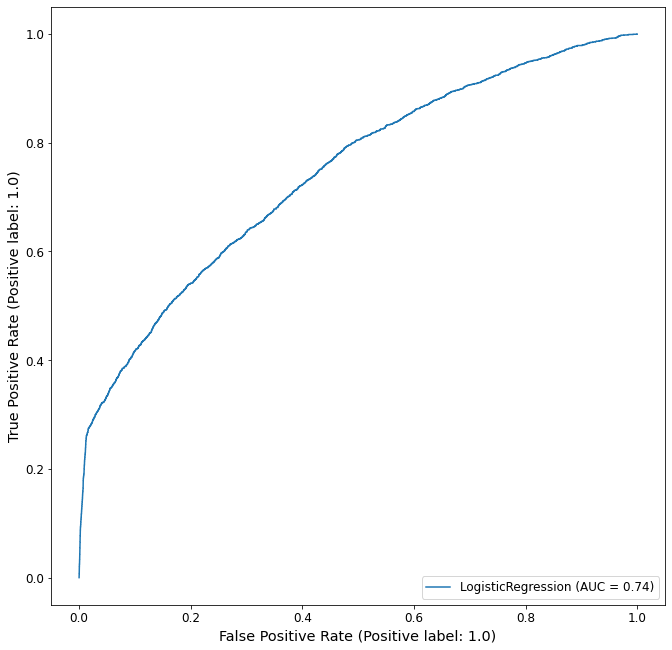

In [34]:
plot_roc_curve(rlr_model, X_logit_validation, df_validation['IsBadBuy'])

## Feature Engineering for Tree Based Models

In many ways, feature engineering is less important for tree based models. This is because tree based models can learn both interactions and how to pick out a single class. Think carefully about a) why it is unnecessary relative to logistic regression and b) why it might be harmful (particularly when you set `max_features` to something less than all features).

However, that does not mean that it is entirely irrelevant. First, we can let our trees do less work finding the most important relationships if we can construct some of them for it, and we can save some splitting that the tree would normally have to do if we provide some dummy variables. We can also help point it in the right direction if we provide some interactions.

Additionally, we can't just give our tree a list of strings (which is what a categorical variable is). Computers work with numbers so we need to use numbers. So, if we don't use dummy variables for a particular variable, we will still need to _encode_ it. The most common way is with an ordinal encoding scheme. Ordinal encoding assigns an integer to each category, and then that number replaces the original category. We can do this with the `OrdinalEncoder` function from `sklearn`. The `OrdinalEncoder` works just like the imputers we have seen before, but instead of imputing values it replaces categories with numbers so that the trees can work with them. Note that it is important to `.fit()` on your training data, and then use the _same encoder_ to `.transform()` the validation set (and later the testing set). If you re-fit the encoder on the validation or testing set, you may end up with categories being assigned to different numbers and your model would just be acting randomly on things.

First let's make a list of what to include broken up into three categories: continuous variables, ordinal encoded categorical variables, and dummy encoded categorical variables.

In [ ]:
continuous_features_trees = ['VehOdo']
cat_ordinal_features_trees = ['VehYear', 'Year', 'Size', 'Transmission']
cat_dummy_features_trees = ['WheelTypeID', 'Auction']

Above we chose to create dummy variables for `WheelTypeID` because there are only three possible values and we already know that is an important variable. We are ordinal encoding `VehYear` because it would add 9 columns to our data if we tried to dummy encode it. That could throw off the random feature selection for things like random forests.

We can use these selected variables to make our training `X` matrix.

In [ ]:
X_tree_train = df_smaller_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train = df_smaller_train['IsBadBuy']

That gives us the continuous features and the ordinal features, but we don't yet have the dummy features. The best way to get those is using the `dmatrix` command, which is really similar to `dmatrices`, but it doesn't give us back a `y` (which we already have from above. The syntax is very similar but we only specify the right hand side of the formula. For example, here we would do this.

In [ ]:
formula_tree = "0 + " + " + ".join(cat_dummy_features_trees)

In [ ]:
formula_tree

The `0` above says don't add in an intercept. We can also easily add in interaction variables if we want to.

In [ ]:
formula_tree = "0 + " + " + ".join(cat_dummy_features_trees) + " + VehOdo:Transmission"

In [ ]:
formula_tree

Note that I used `:` when adding the interaction term `VehOdo:Transmission`. This tells `dmatrix` to just add the interaction, not the individual variables (which we already have in our model).

Now we can create our dummy variables and interactions easily.

In [ ]:
X_tree_train_patsy = dmatrix(formula_tree, df_smaller_train, return_type="dataframe")

In [ ]:
X_tree_train_patsy

It did exactly what we were expecting, but we need to add it to our `X_tree_train` to get everything in the same place. We can concatenate the two dataframes with `pd.concat()`.

In [ ]:
X_tree_train = pd.concat([X_tree_train, X_tree_train_patsy], axis=1)

This added the two dataframes together, and we can check to make sure it is what we want.

In [ ]:
X_tree_train

The final step is we need to ordinal encode any variables that are not dummies with `OrdinalEncoder`.

In [ ]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_tree_train[cat_ordinal_features_trees])
X_tree_train[cat_ordinal_features_trees] = ordinal_encoder.transform(X_tree_train[cat_ordinal_features_trees])

In [ ]:
X_tree_train

One final detail, xgboost does not like `[` or `]` in column names (e.g. `WheelTypeID[MISSING]`), so we will replace those with `(` and `)`.

In [ ]:
X_tree_train.columns = X_tree_train.columns.str.replace('[', '(').str.replace(']', ')')

In [ ]:
X_tree_train.columns

Let's go ahead and transform our validation set.

In [ ]:
X_tree_validation = df_validation[continuous_features_trees + cat_ordinal_features_trees]
y_tree_validation = df_validation['IsBadBuy']

X_tree_validation_patsy = build_design_matrices([X_tree_train_patsy.design_info], df_validation, return_type="dataframe")[0]

X_tree_validation = pd.concat([X_tree_validation, X_tree_validation_patsy], axis=1)

X_tree_validation[cat_ordinal_features_trees] = ordinal_encoder.transform(X_tree_validation[cat_ordinal_features_trees])

X_tree_validation.columns = X_tree_validation.columns.str.replace('[', '(').str.replace(']', ')')

Now we are ready to start training trees.

## Decision Tree

Let's build our decision tree. Note that the only difference between this and the decision tree regression we've used before is the function is called `DecisionTreeClassifier` instead of `DecisionTreeRegressor`.

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=30,
                                  min_samples_split=25, 
                                  max_features=.5, 
                                  min_impurity_decrease=.001, 
                                  random_state=201)

In [ ]:
dt_model.fit(X_tree_train, y_tree_train)

In [ ]:
plt.figure(figsize=(20,20))
plot_tree(dt_model, feature_names=X_tree_train.columns, filled=True, fontsize=12)
plt.show()

We can also look at the feature importance.

In [ ]:
pd.DataFrame({'Importance': dt_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

Now we can predict on our validation set.

In [ ]:
dt_pred = dt_model.predict_proba(X_tree_validation)[:,1]

Let's check the accuracy.

In [ ]:
Kaggle_Gini_Index(dt_pred, df_validation['IsBadBuy'])

We probably underfit the above tree.

Let's look at the ROC curve:

In [ ]:
plot_roc_curve(dt_model, X_tree_validation, df_validation['IsBadBuy'])

## Random Forest

Let's build our random frest. Note that the only difference between this and the decision tree regression we've used before is the function is called `RandomForestClassifier` instead of `RandomForestRegressor`.

In [ ]:
rf_model = RandomForestClassifier(n_estimators=500,
                                  max_features=4,
                                  min_samples_leaf=5,
                                  random_state=201,
                                  n_jobs=num_cpus)

In [ ]:
rf_model.fit(X_tree_train, y_tree_train)

We can also look at the feature importance.

In [ ]:
pd.DataFrame({'Importance': rf_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

Now we can predict on our validation set.

In [ ]:
rf_pred = rf_model.predict_proba(X_tree_validation)[:,1]

Let's check the accuracy.

In [ ]:
Kaggle_Gini_Index(rf_pred, df_validation['IsBadBuy'])

And the ROC curve:

In [ ]:
plot_roc_curve(rf_model, X_tree_validation, df_validation['IsBadBuy'])

That's definitely better, but we can probably do even better.

## Boosted trees model

Again, the only real difference between what we have seen before and this is that we will use `XGBClassifier` instead of the decision tree or boosted trees.

In [ ]:
xgb_model = XGBClassifier(max_depth=6,
                          n_estimators = 50,
                          learning_rate=.1,
                          random_state=201)

In [ ]:
xgb_model.fit(X_tree_train, y_tree_train)

We can also look at the feature importance.

In [ ]:
pd.DataFrame({'Importance': rf_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

Now we can predict on our validation set.

In [ ]:
xgb_pred = xgb_model.predict_proba(X_tree_validation)[:,1]

Let's check the accuracy.

In [ ]:
Kaggle_Gini_Index(xgb_pred, df_validation['IsBadBuy'])

And the ROC curve:

In [ ]:
plot_roc_curve(xgb_model, X_tree_validation, df_validation['IsBadBuy'])

Now we're cooking with gas. I bet you could tune this even higher with `GridSearchCV` and more careful parameter selection...

## Predict on the Test Set

After you have gone through and chosen your specific model and the parameters from the model using your validation set, it is now time to go back and redo everything on the full training set in order to make predictions on the test set. Note that the below will assume you want to make the same choices around formatting data as you did for the `df_smaller_train` set above. The below is really just going through the above steps to create the data but replacing `df_smaller_train` with `df_train` and `df_validation` with `df_test`.

First, we will refit the imputers and impute on `df_train` and `df_test`.

In [ ]:
continuous_imputer_final = SimpleImputer(missing_values=np.nan, strategy='mean')
categorical_imputer_final = CategoricalImputer(other_threshold=.01)

In [ ]:
continuous_imputer_final.fit(df_train[continuous_features])
df_train[continuous_features] = continuous_imputer_final.transform(df_train[continuous_features])
df_test[continuous_features] = continuous_imputer_final.transform(df_test[continuous_features])

In [ ]:
categorical_imputer_final.fit(df_train[categorical_features])
df_train[categorical_features] = categorical_imputer_final.transform(df_train[categorical_features])
df_test[categorical_features] = categorical_imputer_final.transform(df_test[categorical_features])

Now, we will re-create the linear regression data necessary to train and predict. This will use the same `formula_linear` you created when you were first training the logistic regression.

In [ ]:
y_logit_train_final, X_logit_train_final = dmatrices(formula_linear, df_train, return_type="dataframe")

Now we can build the `X_test` matrix in order to make final predictions from the linear regression models.

In [ ]:
X_logit_test = build_design_matrices([X_logit_train_final.design_info], df_test, return_type="dataframe")[0]

Now, we can retrain the logistic regression model on the new data set. NOTE: You should adjust the parameters values to what you chose above.

In [ ]:
%%time
logit_model_final = LogisticRegression(C=1/10, random_state=201)
logit_model_final.fit(X_logit_train_final, y_logit_train_final)

Let's make our final prediction with the logistic model.

In [ ]:
logit_pred_final = logit_model_final.predict_proba(X_logit_test)[:,1]

Now, we will recreate the tree based models data set.

In [ ]:
X_tree_train_final = df_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train_final = df_train['IsBadBuy']

If you created dummy variables or interactions, you will want to run the next line. If not, you can skip it. This will use the same `formula_tree` you made when first setting up the data set for trees.

In [ ]:
X_tree_train_patsy_final = dmatrix(formula_tree, df_train, return_type="dataframe")
X_tree_train_final = pd.concat([X_tree_train_final, X_tree_train_patsy_final], axis=1)

Now we ordinal encode variables. If you did not choose to ordinal encode any variables, you can skip this.

In [ ]:
ordinal_encoder_final = OrdinalEncoder()
ordinal_encoder_final.fit(X_tree_train_final[cat_ordinal_features_trees])
X_tree_train_final[cat_ordinal_features_trees] = ordinal_encoder_final.transform(X_tree_train_final[cat_ordinal_features_trees])

Finally, we have to replace the characters that xgboost doesn't like.

In [ ]:
X_tree_train_final.columns = X_tree_train_final.columns.str.replace('[', '(').str.replace(']', ')')

Now, we need to do these steps for the test set.

In [ ]:
X_tree_test = df_test[continuous_features_trees + cat_ordinal_features_trees]

X_tree_test_patsy = build_design_matrices([X_tree_train_patsy_final.design_info], df_test, return_type="dataframe")[0]

X_tree_test = pd.concat([X_tree_test, X_tree_test_patsy], axis=1)

X_tree_test[cat_ordinal_features_trees] = ordinal_encoder_final.transform(X_tree_test[cat_ordinal_features_trees])

X_tree_test.columns = X_tree_test.columns.str.replace('[', '(').str.replace(']', ')')

Now we can retrain our tree based models, and make final predictions. Note you should adjust parameters to whatever you found above, and you may not need to run all of the below code if you don't intend to use some of the models.

First, the decision tree.

In [ ]:
%%time
dt_model_final = DecisionTreeClassifier(max_depth=30,
                                        min_samples_split=25, 
                                        max_features=.5, 
                                        min_impurity_decrease=.001, 
                                        random_state=201)
dt_model_final.fit(X_tree_train_final, y_tree_train_final)
dt_pred_final = dt_model_final.predict_proba(X_tree_test)[:,1]

Second, the random forest.

In [ ]:
%%time
rf_model_final = RandomForestClassifier(n_estimators=500,
                                        max_features=4,
                                        min_samples_leaf=5,
                                        random_state=201,
                                        n_jobs=num_cpus)
rf_model_final.fit(X_tree_train_final, y_tree_train_final)
rf_pred_final = rf_model_final.predict_proba(X_tree_test)[:,1]

Finally, the boosted tree.

In [ ]:
%%time
xgb_model_final = XGBClassifier(max_depth=6,
                                n_estimators = 50,
                                learning_rate=.1,
                                random_state=201)
xgb_model_final.fit(X_tree_train_final, y_tree_train_final)
xgb_pred_final = xgb_model_final.predict_proba(X_tree_test)[:,1]

Now you can choose to ensemble however you would like. Below is one possibility of just ensembling all of the above models equally.

In [ ]:
final_pred = (logit_pred_final + dt_pred_final + rf_pred_final + xgb_pred_final)/4

Let's take a look at our `final_pred`.

In [ ]:
final_pred

# Make forecasts into the testing set and prepare submissions to Kaggle

The final step is to make forecasts into the testing set and then submit to Kaggle. The submission expects a csv with two columns. The first is `RefId` and the second is `IsBadBuy` with the probability of the car being a bad buy in the second column. So, you should save the predictions into a variable called `final_pred`.

After you have your predictions in the variables `final_pred` (it should have 48,707 values), then you can run the below line to generate your final predictions. If you have not made your `final_pred`, then you will not be able to run the below lines without error.

In [ ]:
submission = df_test[['RefId']].copy()
submission['IsBadBuy'] = final_pred
submission.to_csv('submission.csv', index=False)

In [ ]:
submission